# TaskLoader tour

This notebook demonstrates how you can set up `TaskLoader` objects to load different kinds of tasks that can be used to train models that accomplish different objectives. The `TaskLoader` is very flexible and can be used to load tasks for spatial interpolation, forecasting, and downscaling, or some combination of these. The ability to use `TaskLoader`s to automatically compose ConvNP models in TensorFlow or PyTorch adds to the convenience of `deepsensor`.

In this notebook, we will demonstrate a few different tasks that can be loaded using `TaskLoader` objects. Antarctic temperature will be our target variable, using gridded ERA5 data and off-grid station data to construct tasks. However, the same principles can be applied to any other target variable and data source, as long as the data is in `xarray` or `pandas` format.

## Imports/set-up

In [1]:
# Load the "autoreload" extension so that code can change
%load_ext autoreload
# Always reload modules so that as you change code in src, it gets loaded
%autoreload 2

In [2]:
# import deepsensor.torch as deepsensor
import deepsensor.tensorflow as deepsensor

2023-07-08 13:49:13.163937: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-08 13:49:13.319916: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [3]:
from deepsensor.data.processor import DataProcessor
from deepsensor.data.loader import TaskLoader
from deepsensor.model.convnp import ConvNP

In [4]:
import pandas as pd
import xarray as xr

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")

## Load data

In [5]:
# era5_raw_ds = xr.open_mfdataset('../../deepsensor_old/data/antarctica/gridded/processed/*/*.nc')
era5_raw_ds = xr.open_mfdataset('../../deepsensor_old/data/antarctica/gridded/interim/tas_anom/*.nc')
era5_raw_ds

<xarray.Dataset>
Dimensions:    (time: 25933, y: 280, x: 280)
Coordinates:
  * time       (time) datetime64[ns] 1950-01-01 1950-01-02 ... 2020-12-31
  * y          (y) float64 3.488e+06 3.462e+06 ... -3.462e+06 -3.488e+06
  * x          (x) float64 -3.488e+06 -3.462e+06 ... 3.462e+06 3.488e+06
    dayofyear  (time) int64 dask.array<chunksize=(365,), meta=np.ndarray>
Data variables:
    t2m        (time, y, x) float32 dask.array<chunksize=(365, 280, 280), meta=np.ndarray>

In [6]:
aux_raw_ds = xr.open_mfdataset('../../deepsensor_old/data/antarctica/auxiliary/interim/*25000m/*.nc')
aux_raw_ds = aux_raw_ds[['surface', 'mask']]
aux_raw_ds

<xarray.Dataset>
Dimensions:  (y: 280, x: 280)
Coordinates:
  * y        (y) float64 3.488e+06 3.462e+06 3.438e+06 ... -3.462e+06 -3.488e+06
  * x        (x) float64 -3.488e+06 -3.462e+06 ... 3.462e+06 3.488e+06
    lat      (y, x) float32 dask.array<chunksize=(280, 280), meta=np.ndarray>
    lon      (y, x) float32 dask.array<chunksize=(280, 280), meta=np.ndarray>
Data variables:
    surface  (y, x) float32 dask.array<chunksize=(280, 280), meta=np.ndarray>
    mask     (y, x) float64 dask.array<chunksize=(280, 280), meta=np.ndarray>
Attributes: (12/19)
    Author:                      Mathieu Morlighem
    Data_citation:               Morlighem M. et al., (2019), Deep glacial tr...
    Notes:                       Data processed at the Department of Earth Sy...
    Projection:                  Polar Stereographic South (71S,0E)
    Title:                       BedMachine Antarctica
    ice_density (kg m-3):        917.0
    ...                          ...
    spacing:                     500
    valid_range:                 [0. 4.]
    version:                     15-Jul-2020 (v2.0)
    xmin:                        -3333000
    ymax:                        3333000
    Conventions:                 CF-1.7

In [7]:
station_raw_df = pd.read_csv('../../deepsensor_old/data/antarctica/station/interim/XY_station.csv')
station_raw_df = station_raw_df.rename(columns={'date': 'time'})
station_raw_df['time'] = pd.to_datetime(station_raw_df['time'])
station_raw_df = station_raw_df.set_index(['time', 'y', 'x', 'station']).sort_index()[['tas']]
station_raw_df

tas
time       y             x             station                    
1948-04-01 -3.638593e+06  1.401585e+06 Macquarie_Island   5.885714
1948-04-02 -3.638593e+06  1.401585e+06 Macquarie_Island   6.675000
1948-04-03 -3.638593e+06  1.401585e+06 Macquarie_Island   4.775000
1948-04-04 -3.638593e+06  1.401585e+06 Macquarie_Island   5.150000
1948-04-05 -3.638593e+06  1.401585e+06 Macquarie_Island   4.037500
...                                                            ...
2022-06-14  1.447591e+06 -6.904655e+05 Halley_6a        -22.577778
2022-06-15  5.380525e+05 -1.606516e+06 Sky_Blu          -26.587500
            8.072843e+05 -1.351549e+06 Limbert          -23.887500
            9.270759e+05 -2.308923e+06 Rothera           -9.895833
            9.847784e+05 -1.717203e+06 Butler Island    -19.669524

[941850 rows x 1 columns]

## Normalise data

In [8]:
data_processor = DataProcessor(x1_name='y', x1_map=(0, 3.5e6), x2_name='x', x2_map=(0, 3.5e6))

In [9]:
era5_ds, station_df = data_processor([era5_raw_ds, station_raw_df])
aux_ds = data_processor(aux_raw_ds, method="min_max")

### Set up model and task loader

In [10]:
task_loader = TaskLoader(context=[station_df, era5_ds, aux_ds], target=[station_df, era5_ds], links=[(0, 0)])
print(task_loader)

TaskLoader(3 context sets, 2 target sets)
Context variable IDs: (('tas',), ('t2m',), ('surface', 'mask'))
Target variable IDs: (('tas',), ('t2m',))


In [11]:
model = ConvNP(data_processor, task_loader, verbose=False)
date = "2018-01-01"
task = task_loader(date, ("split", 100, "all"), ("split", "all"), split_frac=0.5)
print(task)

2023-07-08 13:49:59.540077: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13118 MB memory:  -> device: 0, name: NVIDIA A2, pci bus id: 0000:98:00.0, compute capability: 8.6


time: 2018-01-01 00:00:00
flag: None
X_c: [(2, 34), (2, 100), ((1, 280), (1, 280))]
Y_c: [(1, 34), (1, 100), (2, 280, 280)]
X_t: [(2, 35), ((1, 280), (1, 280))]
Y_t: [(1, 35), (1, 280, 280)]



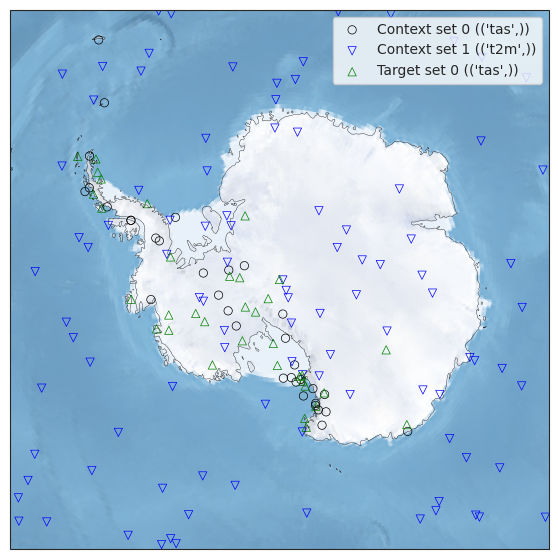

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7), subplot_kw=dict(projection=ccrs.LambertAzimuthalEqualArea(0, -90)))
ax.set_extent([-3.5e6, 3.5e6, -3.5e6, 3.5e6], crs=ccrs.LambertAzimuthalEqualArea(0, -90))
ax.stock_img()
ax.coastlines(linewidth=0.25)
deepsensor.plot.offgrid_context(ax, task, data_processor, task_loader, plot_target=True, add_legend=True, linewidths=0.5)
plt.show()

2023-07-08 13:50:04.434206: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


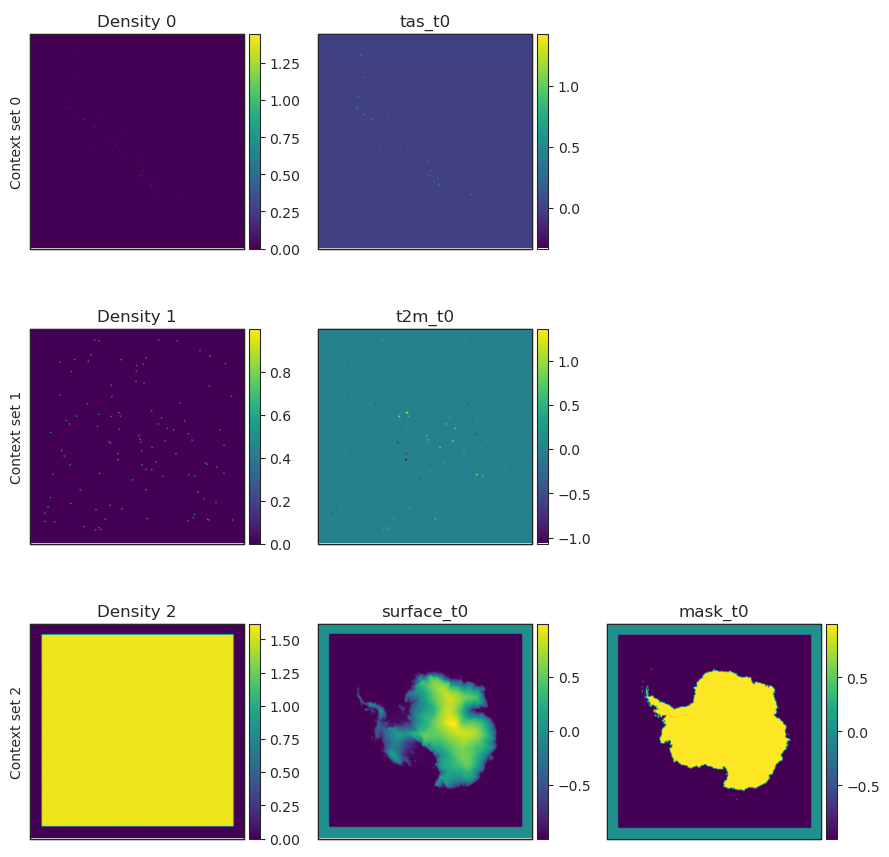

In [13]:
# Plot the whole encoding
fig = deepsensor.plot.context_encoding(model, task, task_loader)
plt.show()

## Train model

In [32]:
import numpy as np
from tqdm import tqdm
def gen_train_tasks():
    train_dates = pd.date_range("2000-01-01", "2009-12-31", freq="D")[::3]
    train_tasks = []
    for date in train_dates:
        n_era5 = np.random.randint(0, 500)
        station_split_frac = np.random.uniform(0.0, 1.0)
        task = task_loader(date, ("split", n_era5, "all"), ("split", "all"), split_frac=station_split_frac)
        train_tasks.append(task)
    return train_tasks
train_tasks = gen_train_tasks()

In [33]:
train_tasks[0]

time: Timestamp/2000-01-01 00:00:00
flag: NoneType/None
X_c: ['ndarray/float32/(2, 45)', 'ndarray/float32/(2, 470)', ('ndarray/float32/(1, 280)', 'ndarray/float32/(1, 280)')]
Y_c: ['ndarray/float32/(1, 45)', 'ndarray/float32/(1, 470)', 'ndarray/float32/(2, 280, 280)']
X_t: ['ndarray/float32/(2, 24)', ('ndarray/float32/(1, 280)', 'ndarray/float32/(1, 280)')]
Y_t: ['ndarray/float32/(1, 24)', 'ndarray/float32/(1, 280, 280)']

In [34]:
from deepsensor.train.train import train_epoch

n_epochs = 10
losses = []
for epoch in range(n_epochs):
    batch_losses = train_epoch(model, train_tasks, progress_bar=True)
    losses.append(np.mean(batch_losses))
    train_tasks = gen_train_tasks()  # Regenerate train tasks each epoch

 27%|█████████████████▌                                               | 329/1218 [02:31<06:50,  2.17it/s]


KeyboardInterrupt: 

Text(0, 0.5, 'Loss')

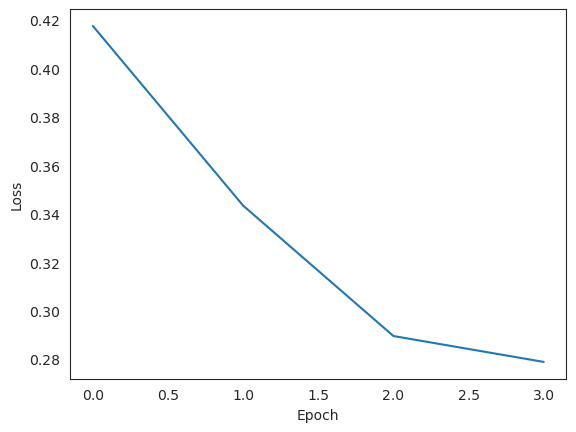

In [35]:
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")

## Predict on new task

In [43]:
task = task_loader(date, ("all", 0, "all"))  # Pass all stations, no ERA5, and all auxilliary data
task

time: Timestamp/2009-12-30 00:00:00
flag: NoneType/None
X_c: ['ndarray/float32/(2, 78)', 'ndarray/float32/(2, 0)', ('ndarray/float32/(1, 280)', 'ndarray/float32/(1, 280)')]
Y_c: ['ndarray/float32/(1, 78)', 'ndarray/float32/(0,)', 'ndarray/float32/(2, 280, 280)']
X_t: ['ndarray/float32/(2, 78)', ('ndarray/float32/(1, 280)', 'ndarray/float32/(1, 280)')]
Y_t: ['ndarray/float32/(1, 78)', 'ndarray/float32/(1, 280, 280)']

In [44]:
mean_ds, std_ds = model.predict(task, X_t=era5_raw_ds)
mean_ds

<xarray.Dataset>
Dimensions:  (time: 1, y: 280, x: 280)
Coordinates:
  * time     (time) datetime64[ns] 2009-12-30
  * y        (y) float64 3.488e+06 3.462e+06 3.438e+06 ... -3.462e+06 -3.488e+06
  * x        (x) float64 -3.488e+06 -3.462e+06 ... 3.462e+06 3.488e+06
Data variables:
    tas      (time, y, x) float32 -6.833 -10.02 -11.31 ... -8.633 -13.02 -21.02
    t2m      (time, y, x) float32 0.6118 0.6294 0.532 ... 0.3931 0.4262 0.4532

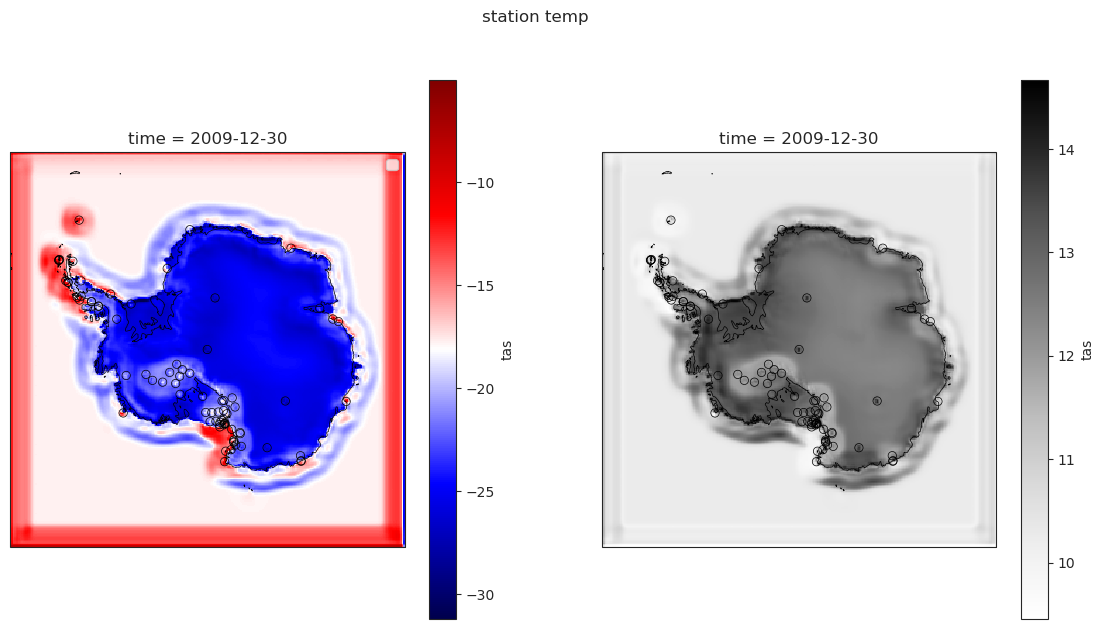

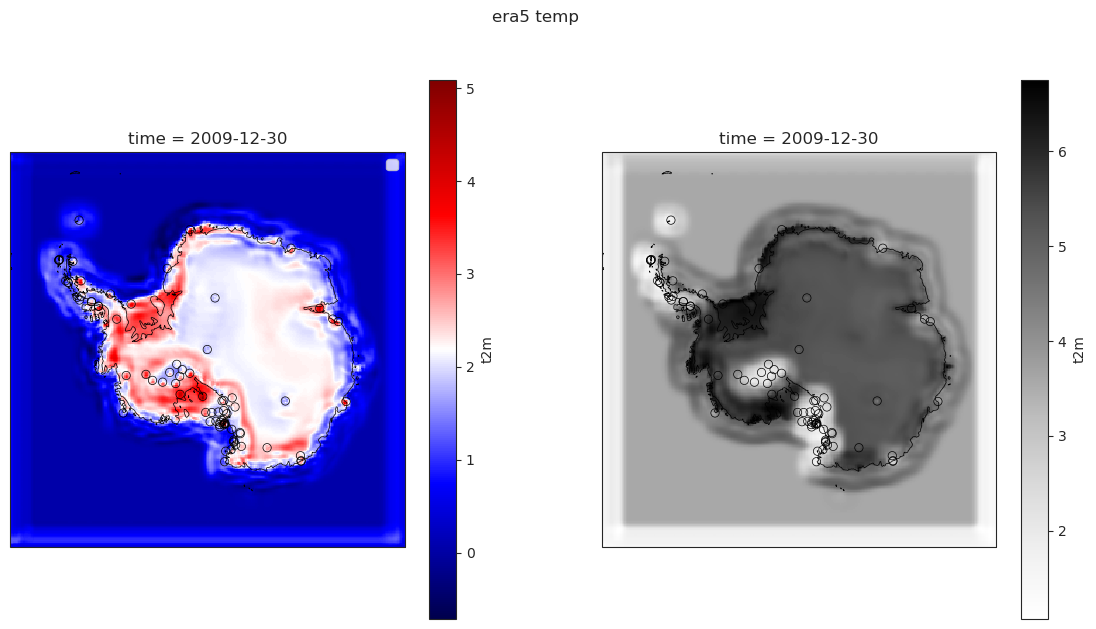

In [40]:
task = task_loader(date, ("all", 0, "all"))  # Pass all stations, and no ERA5
mean_ds, std_ds = model.predict(task, X_t=era5_raw_ds)
for var, title in [("tas", "station temp"), ("t2m", "era5 temp")]:
    fig, axes = plt.subplots(1, 2, figsize=(14, 7), subplot_kw=dict(projection=ccrs.LambertAzimuthalEqualArea(0, -90)))
    mean_ds[var].plot(ax=axes[0], vmin=mean_ds[var].min(), vmax=mean_ds[var].max(), cmap="seismic")
    std_ds[var].plot(ax=axes[1], cmap="Greys")
    for ax in axes:
        ax.coastlines(linewidth=0.5)
    deepsensor.plot.offgrid_context(axes, task, data_processor, task_loader, add_legend=True, linewidths=0.5)
    plt.suptitle(title)

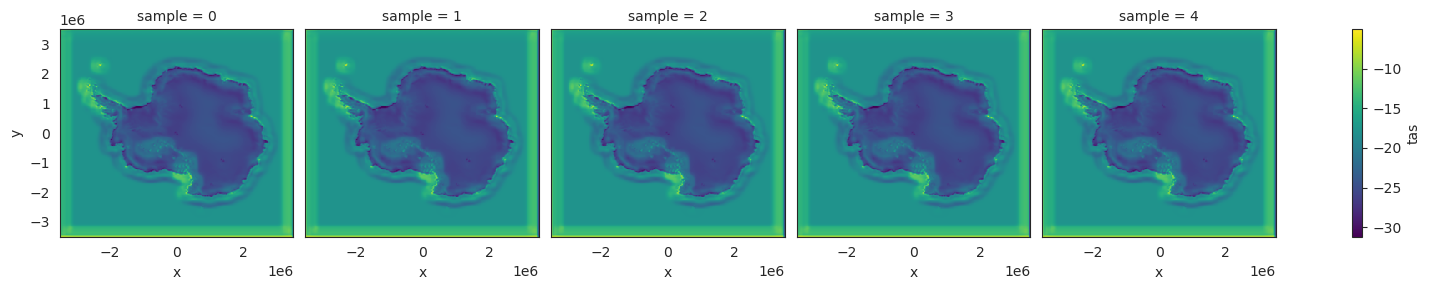

In [49]:
# AR sample
task = task_loader(date, ("all", 0, "all"))  # Pass all stations, no ERA5, and all auxilliary data
mean, std, samples = model.predict(task, X_t=era5_raw_ds, n_samples=5)
samples.tas.isel(time=0).plot(col="sample", col_wrap=5)